

### Instituto Tecnológico de Costa Rica (ITCR)
### Escuela de Computación
### Curso: Inteligencia Artificial
 
### Proyecto Investigación

Profesora: María Auxiliadora Mora

Estudiantes:
 1. Pablo Alberto Muñoz Hidalgo
 2. Luis Andrés Rojas Murillo

Entregables: Un archivo en Jupyter ( .IPYNB ). 

Modo de trabajo: En parejas.

---

Objetivo: 

Problema: 

### Descripción del algoritmo

La generación de imágenes con Transformers ha supuesto un avance significativo, los transformadores son conocidos por su capacidad para capturar relaciones de largo alcance y modelar dependencias globales en los datos, lo que los hace especialmente adecuados para tareas de procesamiento del lenguaje natural. Sin embargo, su aplicación en la generación de imágenes ha resultado prometedora y ha dado lugar a interesantes avances en este campo.

Un ejemplo notable es ImageGPT, desarrollado por OpenAI. ImageGPT es una extensión del modelo GPT-2, entrenado originalmente para tareas de procesamiento del lenguaje natural. Sin embargo, OpenAI adaptó este modelo para predecir el valor del siguiente píxel de una imagen, lo que permite generar imágenes tanto incondicionales como condicionales. A pesar de haber sido entrenado en imágenes de baja resolución sin etiquetas, ImageGPT ha demostrado aprender representaciones de imagen sólidas.

Otro enfoque interesante es el método Taming Transformer, que combina el sesgo inductivo de las redes neuronales convolucionales (CNN) con la expresividad de los Transformers. En este caso, se utiliza una CNN VQGAN para aprender un libro de códigos que representa partes visuales ricas en contexto. Estos códigos se utilizan posteriormente para sintetizar imágenes de alta resolución. Esta combinación de técnicas permite capturar tanto la estructura local de las imágenes (gracias a las CNN) como las relaciones de largo alcance (gracias a los Transformers), mejorando la calidad y coherencia de las imágenes generadas.

En resumen, la generación de imágenes con Transformers ha ampliado el alcance de los modelos basados en esta arquitectura más allá del procesamiento del lenguaje natural. Los enfoques mencionados, como ImageGPT, Taming Transformer, ViTGAN y StyleSwin, han demostrado su eficacia en la generación de imágenes de alta resolución, capturando tanto la estructura local como las relaciones de largo alcance en los datos visuales. Estos avances prometen abrir nuevas posibilidades en la generación automática de contenidos visuales y aplicaciones que van desde la creación artística a la síntesis de imágenes realistas en campos como el diseño gráfico, la realidad virtual y la animación.

### Ejemplo de transformers aplicado a imágenes

In [419]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from timm import create_model

Se utiliza un modelo preentrenado para facilitar el proceso y acortar la presentación

In [420]:
model_name = "vit_base_patch16_224"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
model = create_model(model_name, pretrained=True).to(device)

device =  cpu


Se definen las variables basicas para el modelo, como: tamaño de la imagen reescalada, normalizacion de colores etc...

In [421]:
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

Se define la imagen y los labels que va a utilizar la red

In [422]:

imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

#img = PIL.Image.open('bird.jpg')
#img = PIL.Image.open('santorini.png')
#img = PIL.Image.open('cat.jpg')
#EJEMPLOS PARCIALES
#img = PIL.Image.open('butterfly.jpg')
#EJEMPLO COMPLICADO
#img = PIL.Image.open('plane.jpg')
#EJEMPLO DE RESULTADO CERCANO
#img = PIL.Image.open('bed.jpg')

img_tensor = transforms(img).unsqueeze(0).to(device)

Se imprime la imagen que se va a utilizar y los píxeles, hasta ahora nada del otro mundo que hayamos visto en proyectos anteriores

Inference Result:
airliner



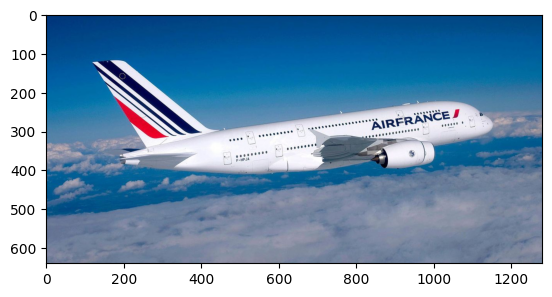

In [423]:
output = model(img_tensor)

print("Inference Result:")
print(imagenet_labels[int(torch.argmax(output))])
plt.imshow(img)

In [424]:
patches = model.patch_embed(img_tensor)  # patch embedding convolution
print("Tensor de la imagen: ", img_tensor.shape)
print("Integracion de los sectores o parches: ", patches.shape)

Tensor de la imagen:  torch.Size([1, 3, 224, 224])
Integracion de los sectores o parches:  torch.Size([1, 196, 768])


Meramente con el proposito representativo de lo que ve la red neuronal cuando divide la imagen aqui se imprime para simular que somos la red.

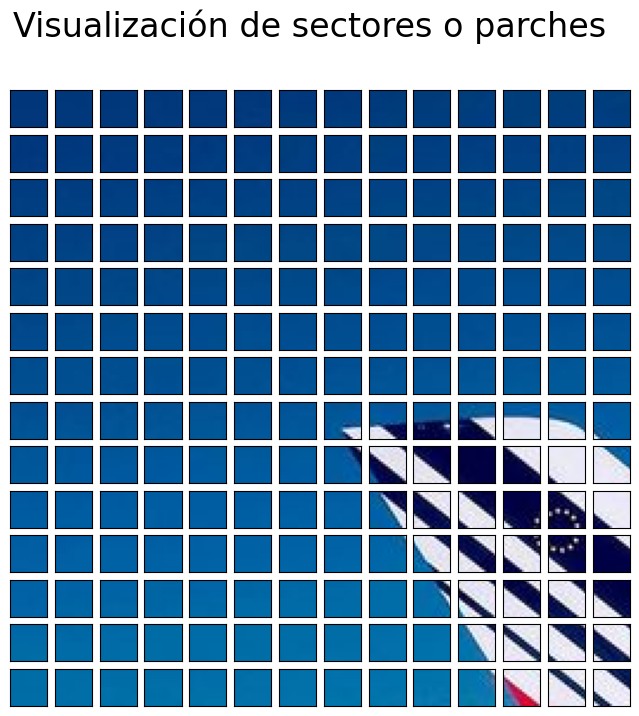

In [425]:
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualización de sectores o parches", fontsize=24)
img = np.asarray(img)
for i in range(0, 196):
    x = i % 14
    y = i // 14
    patch = img[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

In [426]:
pos_embed = model.pos_embed
print(pos_embed.shape)

torch.Size([1, 197, 768])


Aqui se visualizan las similaridades entre las posiciones de integración, esto muestra donde hay similitudes con los otros sectores de la imagen, esto lo hace la red para de esta manera predecir como se veria una imagen similar y poder generar algo lo más parecido posible

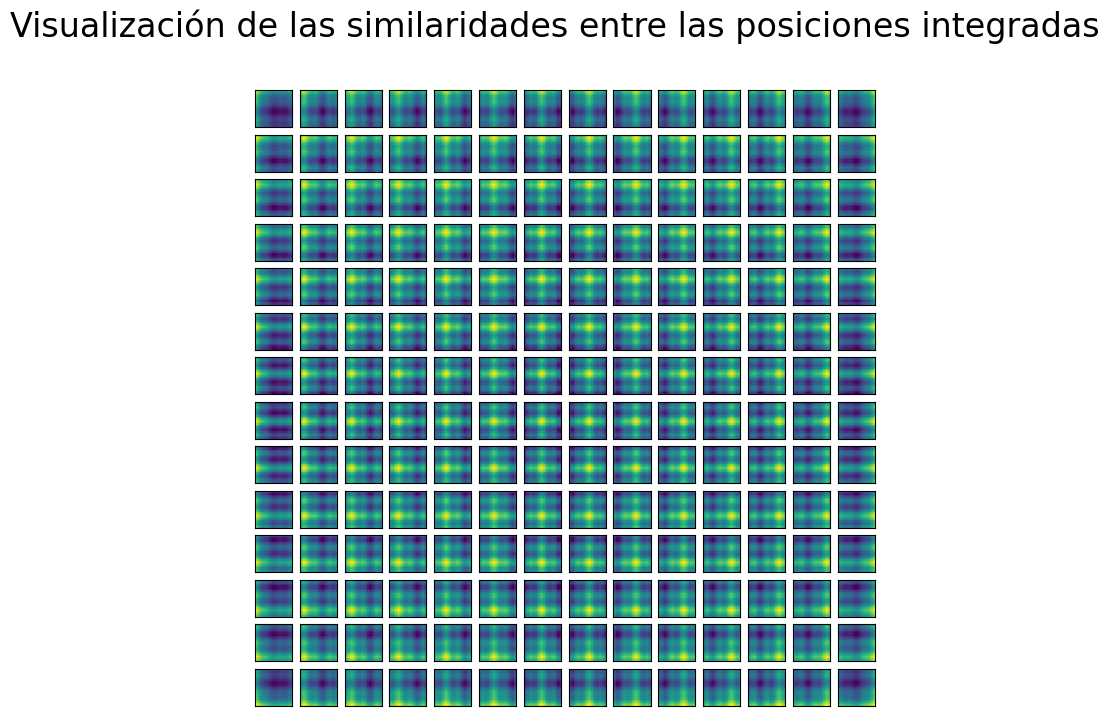

In [427]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualización de las similaridades entre las posiciones integradas", fontsize=24)
for i in range(1, pos_embed.shape[1]):
    sim = F.cosine_similarity(pos_embed[0, i:i+1], pos_embed[0, 1:], dim=1)
    sim = sim.reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

In [428]:
transformer_input = torch.cat((model.cls_token, patches), dim=1) + pos_embed
print("Tamaño del input para el transformer: ", transformer_input.shape)

Tamaño del input para el transformer:  torch.Size([1, 197, 768])


In [429]:
print("Tamaño del input para el transformer vector z0: ", transformer_input.shape)
x = transformer_input.clone()
for i, blk in enumerate(model.blocks):
    print("Codificador de transformer numero: {}".format(i))
    x = blk(x)
x = model.norm(x)
transformer_output = x[:, 0]
print("Salida del transformer, vector z12-0:", transformer_output.shape)

Tamaño del input para el transformer vector z0:  torch.Size([1, 197, 768])
Codificador de transformer numero: 0
Codificador de transformer numero: 1
Codificador de transformer numero: 2
Codificador de transformer numero: 3
Codificador de transformer numero: 4
Codificador de transformer numero: 5
Codificador de transformer numero: 6
Codificador de transformer numero: 7
Codificador de transformer numero: 8
Codificador de transformer numero: 9
Codificador de transformer numero: 10
Codificador de transformer numero: 11
Salida del transformer, vector z12-0: torch.Size([1, 768])


## ¿Como el transformer le pone atención a la imagen de demo?

In [430]:
print("Bloque de atención del transformer:")
attention = model.blocks[0].attn
print(attention)

Bloque de atención del transformer:
Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (q_norm): Identity()
  (k_norm): Identity()
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)


In [431]:
transformer_input_expanded = attention.qkv(transformer_input)[0]
print("Se expande la dimension del input a: ", transformer_input_expanded.shape)

Se expande la dimension del input a:  torch.Size([197, 2304])


Aquí se puede observar donde es que el algoritmo centra su atención para poder replicar o imitar una imagen similar, hay que tener en cuenta que para la red estas imagenes tienen todo el sentido del mundo ya que como sabemos pasa por diferentes capas las cuales cada una analiza algo diferente y toma los datos más importantes de la imagen.

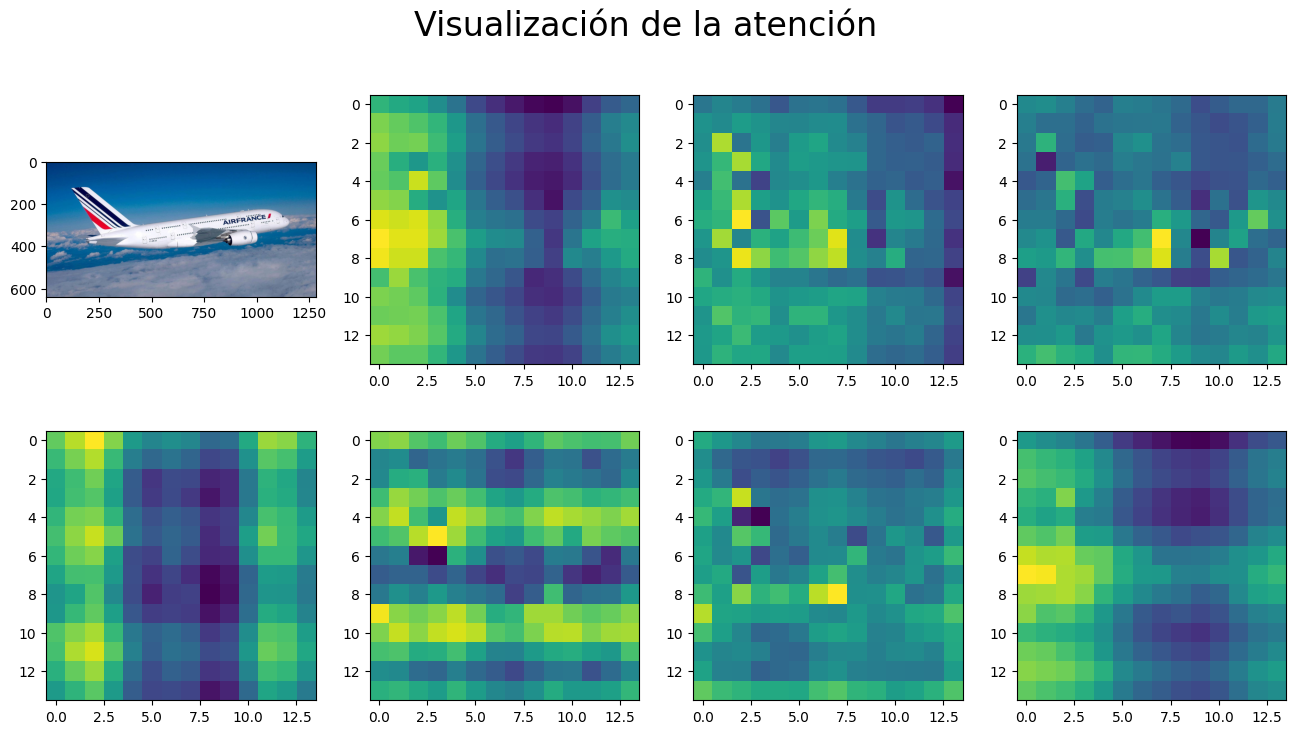

In [432]:
qkv = transformer_input_expanded.reshape(197, 3, 12, 64)  
q = qkv[:, 0].permute(1, 0, 2) 
k = qkv[:, 1].permute(1, 0, 2) 
kT = k.permute(0, 2, 1)  
# Matriz de atención
attention_matrix = q @ kT
# Visualize attention matrix
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualización de la atención", fontsize=24)
img = np.asarray(img)
ax = fig.add_subplot(2, 4, 1)
ax.imshow(img)
for i in range(7):  # visualize the 100th rows of attention matrices in the 0-7th heads
    attn_heatmap = attention_matrix[i, 100, 1:].reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(2, 4, i+2)
    ax.imshow(attn_heatmap)

# 4. Todo tiene sentido, clasificación:

Resultado de la inferencia : id = 404, label name = airliner



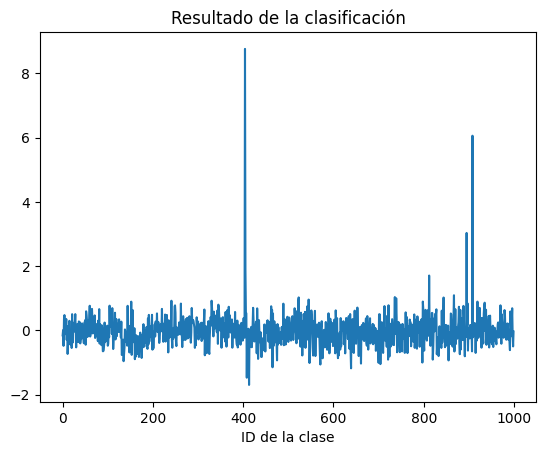

In [433]:
result = model.head(transformer_output)
result_label_id = int(torch.argmax(result))
plt.plot(result.detach().cpu().numpy()[0])
plt.title("Resultado de la clasificación")
plt.xlabel("ID de la clase")
print("Resultado de la inferencia : id = {}, label name = {}".format(
    result_label_id, imagenet_labels[result_label_id]))

Por supuesto el pico más grande o alto es por el que se va a inclinar la red

### Referencias:

Hugging Face. (n.d.). ImageGPT. Retrieved May 15, 2023, from https://huggingface.co/docs/transformers/model_doc/imagegpt

Analytics India Magazine. (n.d.). Generating High Resolution Images Using Transformers. Retrieved May 15, 2023, from https://analyticsindiamag.com/generating-high-resolution-images-using-transformers/

arXiv.org. (n.d.). [2107.04589] ViTGAN: Training GANs with Vision Transformers. Retrieved May 15, 2023, from https://arxiv.org/abs/2107.04589

arXiv.org. (n.d.). StyleSwin: Transformer-based GAN for High-resolution Image Generation. Retrieved May 19, 2023, from https://arxiv.org/abs/2112.10762

Hugging Face. (n.d.). 🤗 Transformers. Retrieved May 19, 2023, from https://huggingface.co/docs/transformers

Honda, H. (n.d.). Vision Transformer Tutorial. Colaboratory. Retrieved May 22, 2023, from https://colab.research.google.com/github/hirotomusiker/schwert_colab_data_storage/blob/master/notebook/Vision_Transformer_Tutorial.ipynb#scrollTo=SVxGzgZE9oeY